In [10]:
from pyne import ace
import matplotlib.pyplot as plt
%matplotlib inline

# Load data, read the xsec table

In [48]:
l = LoadAce('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')

In [53]:
l.set_sigma(102, l.get_sigma(102) * -1)

In [63]:
a.reactions.keys()

odict_keys([2, 5, 16, 17, 28, 37, 41, 51, 52, 53, 54, 55, 56, 91, 102, 203, 207, 444, 600, 649, 800, 801, 802, 803, 804, 805, 806, 807, 849])

In [49]:
libFile = ace.Library('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')

In [50]:
libFile.read()

In [51]:
libFile.find_table(list(libFile.tables.keys())[0])

<ACE Continuous-E Neutron Table: 74184.710nc>

In [52]:
rx = a.find_reaction(102)


# Load another data set, edit an xsec in the data structure

In [34]:
libFile = ace.Library('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.715nc')
libFile.read()
libFile.find_table('74184')
a = libFile.tables[list(libFile.tables.keys())[0]]

e_1 = a.energy
a.sigma_t = a.sigma_t + 100  # nice, we can manipulate data in place!
st_1 = a.sigma_t


Look, it actually changed!

(0.0001, 0.01)

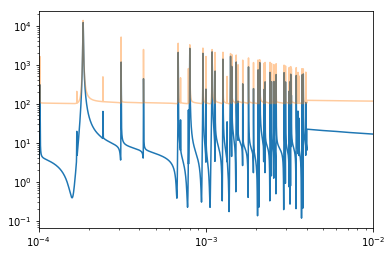

In [35]:
fig, ax = plt.subplots()
ax.loglog(e, st)
ax.loglog(e_1, st_1, alpha=0.4)

ax.set_xlim([1e-4, 1e-2])

# Replace data in the original ACE in a dumb way
The MCNP floats are formatted as .11E, using this we can find the full parsed xsec vector in the ace file then replace it.

In [186]:
format(st[0], '.11E')

'1.07189120000E+02'

In [130]:
# re-read the ace
test_f = open('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc', 'r')

In [187]:
# convert all lines to a single string for searching. 
# replace newlines with spaces, then remove all more than single spaces

single_line = ''
for l in lines:
    single_line += l.replace('\n', ' ')

single_line = re.sub(' +',' ', single_line)

# Find the data in the ace file

Format all parsed data into MCNP format (.11E), join them into a string, then find the index location

In [198]:
def format_mcnp(array):
    original_str_formatted = [format(s, '.11E') for s in st]
    original_str_line = ' '.join(original_str_formatted)
    return original_str_line

In [188]:
original_str_formatted = [format(s, '.11E') for s in st]
original_str_line = ' '.join(original_str_formatted)

In [194]:
first_idx_of_data = single_line.index(original_str_line)
last_idx_of_data = first_idx_of_data + len(original_str_line)

We can access the data using str accessor

In [207]:
single_line[first_idx_of_data: last_idx_of_data];

Now we can replace the data with whatever new data

In [199]:
half_xsec = st / 2
half_xsec_line = format_mcnp(half_xsec)

In [204]:
single_line = single_line.replace(single_line[first_idx_of_data: last_idx_of_data], half_xsec_line)

Finally we can write the data back to an ACE file (need to implement)

* input from the pyne neutron table
* add methods:
* * verify_sum_law
* * multiply xsec
* * format xsec to mcnp
* * read ace as single line
* * * keep track of header data to print back easily
* * write ace


In [ ]:
xsec.verify_sum_laws()
xsec.to_ace() 

In [226]:
import re
import numpy as np

class WriteAce:
    """
    A simplistic way of modifying an existing ace file. Essentially a find and replace. 
    """
    def __init__(self, ace_path):
        
        self.lines, self.header_lines = self._read_ace_to_a_line(ace_path)
        
    def _read_ace_to_a_line(self, ace_path):
        """
        Read the ace file to adjust to a single line with no spaces
        """
        
        with open(ace_path, 'r') as f:
            lines = f.readlines()
            
        # new type header: 2.0.0. (decimal in 2nd place of first word)
        number_of_header_lines = [15 if lines[0].split()[0][1] == '.' else 12][0]

        header_lines = lines[0:number_of_header_lines]
            
        # convert all lines to a single string for searching. 
        # replace newlines with spaces, then remove all more than single spaces

        single_line = ''
        for l in lines[number_of_header_lines:]:
            single_line += l.replace('\n', ' ')

        single_line = re.sub(' +',' ', single_line)
        
        return single_line, header_lines
        
    def format_mcnp(self, array, formatting='.11E'):
        """
        Format values in array based on MCNP formatting
        
        Parameters
        ----------
        array : list-like
        Returns
        -------
        list
        """
        original_str_formatted = [format(s, formatting) for s in st]
        original_str_line = ' '.join(original_str_formatted)
        
        return original_str_line
    
    def replace_array(self, array, replace_with):
        """
        Replaces array with replace_with in the ace file

        Parameters
        ----------
        array : list-like
        replace_with : list-like
        """
        
        if len(array) != len(replace_with):
            raise Exception("Arrays must be equal lenght for replacement.")
        
        original_str_line = self.format_mcnp(array)
        first_idx_of_data = self.lines.index(original_str_line)
        last_idx_of_data = first_idx_of_data + len(original_str_line)

        replace_with_line = self.format_mcnp(replace_with)
        single_line = single_line.replace(single_line[first_idx_of_data: last_idx_of_data], replace_with_line)
        
    def write_ace(self, ace_path_to_write):
        
        split_all_data_str = self.lines.split()
        
        with open(ace_path_to_write, 'w') as f:
            # write the header back to the file 
            [f.write(line) for line in self.header_lines]
            
            values_printed_coutner = 0
            for value in split_all_data_str:
                f.write('{0:>20}'.format(value))
                values_printed_coutner += 1
                if values_printed_coutner == 4:
                    f.write('\n')
                    values_printed_coutner = 0
                    
            # ensure a new line at EOF
            if values_printed_coutner < 4:
                f.write('\n')


In [227]:
wa = WriteAce('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')

In [228]:
wa.write_ace('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/test_74184.710nc')

In [483]:
import SALib.sample.latin as lhs
from scipy.stats.distributions import norm
from scipy.stats import multivariate_normal

In [468]:
samples = lhs.sample({'num_vars': 238, 'bounds': [[0, 1] for i in range(238)]}, 500)

In [501]:
m = multivariate_normal(mean=list([1]*238), cov=np.diag([1]*238))
draws = m.rvs(500)

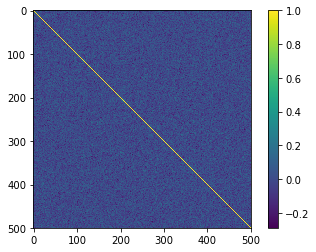

In [503]:
plt.imshow(np.corrcoef(draws))
plt.colorbar()

In [470]:
_FINFO = np.finfo(float) 
_EPS = _FINFO.eps

def gmw(A):
    """Return `(P, L, e)` such that `P.T*A*P = L*L.T - diag(e)`.

    Returns
    -------
    P : 2d array
       Permutation matrix used for pivoting.
    L : 2d array
       Lower triangular factor
    e : 1d array
    Positive diagonals of shift matrix `e`.

    Notes
    -----
    The Gill, Murray, and Wright modified Cholesky algorithm.

    Algorithm 6.5 from page 148 of 'Numerical Optimization' by Jorge
    Nocedal and Stephen J. Wright, 1999, 2nd ed.

    """
    n = A.shape[0]

    # Test matrix.
    #A = array([[4, 2, 1], [2, 6, 3], [1, 3, -0.004]], Float64)
    #n = len(A)
    #I = identity(n, Float64)

    # Calculate gamma(A) and xi(A).
    gamma = 0.0
    xi = 0.0
    for i in range(n):
        gamma = max(abs(A[i, i]), gamma)
        for j in range(i+1, n):
            xi = max(abs(A[i, j]), xi)

    # Calculate delta and beta.
    delta = _EPS * max(gamma + xi, 1.0)
    if n == 1:
        beta = np.sqrt(max(gamma, _EPS))
    else:
        beta = np.sqrt(max(gamma, xi / np.sqrt(n**2 - 1.0), _EPS))

    # Initialise data structures.
    a = 1.0 * A
    r = 0.0 * A
    e = np.zeros(n, dtype=float)
    P = np.eye(n, dtype=float)

    # Main loop.
    for j in range(n):
        # Row and column swapping, find the index > j of the largest
        # diagonal element.
        q = j
        for i in range(j+1, n):
            if abs(a[i, i]) >= abs(a[q, q]):
                q = i

        # Interchange row and column j and q (if j != q).
        if q != j:
            # Temporary permutation matrix for swaping 2 rows or columns.
            p = np.eye(n, dtype=float)

            # Modify the permutation matrix P by swaping columns.
            row_P = 1.0*P[:, q]
            P[:, q] = P[:, j]
            P[:, j] = row_P

            # Modify the permutation matrix p by swaping rows (same as
            # columns because p = pT).
            row_p = 1.0*p[q]
            p[q] = p[j]
            p[j] = row_p

            # Permute a and r (p = pT).
            a = np.dot(p, np.dot(a, p))
            r = np.dot(r, p)

        # Calculate dj.
        theta_j = 0.0
        if j < n-1:
            for i in range(j+1, n):
                theta_j = max(theta_j, abs(a[j, i]))
        dj = max(abs(a[j, j]), (theta_j/beta)**2, delta)

        # Calculate e (not really needed!).
        e[j] = dj - a[j, j]

        # Calculate row j of r and update a.
        r[j, j] = np.sqrt(dj)     # Damned sqrt introduces roundoff error.
        for i in range(j+1, n):
            r[j, i] = a[j, i] / r[j, j]
            for k in range(j+1, i+1):
                a[i, k] = a[k, i] = a[k, i] - r[j, i] * r[j, k]     # Keep matrix a symmetric.

    # The Cholesky factor of A.
    return P, r.T, e

In [471]:
# cholesky-like decomp for non PD matricies. 
T = np.corrcoef(samples.T)
permutation, Q, e = gmw(T) 

# create some fake data and get the cholesky decomposition (lower and upper triangular)
RStar = np.diag([1]*238) + np.diag([-0.5]*237, k=-1) + np.diag([-0.5]*237, k=1)
# this matrix has the same correlation as the desired RStar
P=np.linalg.cholesky(RStar)

# P*Q**-1
dependent_samples=np.dot(samples, np.dot(P, np.linalg.inv(Q)).T)



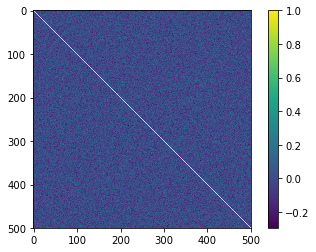

In [472]:
plt.imshow(np.corrcoef(samples))
plt.colorbar()

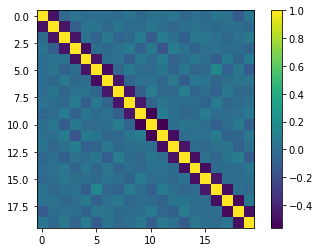

In [474]:
plt.imshow(np.corrcoef(dependent_samples.T)[0:20, 0:20])
plt.colorbar()

In [1]:
from ASAPy import AceIO

/Users/veeshy/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: QAWarning: pyne.rxname is not yet QA compliant.
  return f(*args, **kwds)
/Users/veeshy/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: QAWarning: pyne.ace is not yet QA compliant.
  return f(*args, **kwds)


In [13]:
ae = AceIO.AceEditor('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')

In [3]:
ae.set_sigma(102, ae.get_sigma(102) * 0.5)

In [4]:
ae.apply_sum_rules()

In [5]:
w = AceIO.WriteAce('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')

In [6]:
w.replace_array(ae.original_sigma[102], ae.get_sigma(102))

In [7]:
w.write_ace('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/half_74184.710nc')

In [8]:
ae_1 = AceIO.AceEditor('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/half_74184.710nc')